In [1]:
#Earth Engine API
#Please make sure to follow new authentication for Earth Engine API
import ee

# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize()

Enter verification code:  4/1AX4XfWieerModq8l4gqtW6MrBqpmwIRIZmjId183CpJuqTZsZ874YojOg_g



Successfully saved authorization token.


*** Earth Engine *** Please upgrade your Earth Engine Python client: authentication is changing! https://developers.google.com/earth-engine/guides/python_install


In [2]:
#Other depending libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import folium
import pprint
import branca.colormap as cm

In [3]:
#Some input parameters
# Initial date of interest (inclusive).
i_date = "2015-01-01"

# Final date of interest (exclusive).
f_date = "2022-04-01"

# Define the location of interest with a point (Netherlands, farms).
lon = 29.561714
lat = -1.441599
poi = ee.Geometry.Point(lon, lat)

# A nominal scale in meters of the projection to work in [in meters].
scale = 1000

In [4]:
#From soil texture to hydraulic properties

#Determination of soil texture and properties
# Soil depths [in cm] where we have data.
olm_depths = [0, 10, 30, 60, 100, 200]

# Names of bands associated with reference depths.
olm_bands = ["b" + str(sd) for sd in olm_depths]

In [5]:
#define a function to get the ee.Image associated to the parameter we are interested in (e.g. sand, clay, organic carbon content, etc.).
def get_soil_prop(param):
    """
    This function returns soil properties image
    param (str): must be one of:
        "sand"     - Sand fraction
        "clay"     - Clay fraction
        "orgc"     - Organic Carbon fraction
    """
    if param == "sand":  # Sand fraction [%w]
        snippet = "OpenLandMap/SOL/SOL_SAND-WFRACTION_USDA-3A1A1A_M/v02"
        # Define the scale factor in accordance with the dataset description.
        scale_factor = 1 * 0.01

    elif param == "clay":  # Clay fraction [%w]
        snippet = "OpenLandMap/SOL/SOL_CLAY-WFRACTION_USDA-3A1A1A_M/v02"
        # Define the scale factor in accordance with the dataset description.
        scale_factor = 1 * 0.01

    elif param == "orgc":  # Organic Carbon fraction [g/kg]
        snippet = "OpenLandMap/SOL/SOL_ORGANIC-CARBON_USDA-6A1C_M/v02"
        # Define the scale factor in accordance with the dataset description.
        scale_factor = 5 * 0.001  # to get kg/kg
    else:
        return print("error")

    # Apply the scale factor to the ee.Image.
    dataset = ee.Image(snippet).multiply(scale_factor)

    return dataset

In [6]:
#apply this function to import soil properties
# Image associated with the sand content.
sand = get_soil_prop("sand")

# Image associated with the clay content.
clay = get_soil_prop("clay")

# Image associated with the organic carbon content.
orgc = get_soil_prop("orgc")

In [7]:
#efine a new method for handing Earth Engine tiles and using it to display 
#the clay content of the soil at a given reference depth, to a Leaflet map
def add_ee_layer(self, ee_image_object, vis_params, name):
    """Adds a method for displaying Earth Engine image tiles to folium map."""
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles=map_id_dict["tile_fetcher"].url_format,
        attr="Map Data &copy; <a href='https://earthengine.google.com/'>Google Earth Engine</a>",
        name=name,
        overlay=True,
        control=True,
    ).add_to(self)


# Add Earth Engine drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

my_map = folium.Map(location=[lat, lon], zoom_start=8)

# Set visualization parameters.
vis_params = {
    "bands": ["b0"],
    "min": 0.01,
    "max": 1,
    "opacity": 1,
    "palette": ["white", "#464646"],
}

# Add the sand content data to the map object.
my_map.add_ee_layer(sand, vis_params, "Sand Content")

# Add a marker at the location of interest.
folium.Marker([lat, lon], popup="point of interest").add_to(my_map)

# Add a layer control panel to the map.
my_map.add_child(folium.LayerControl())

# Display the map.
display(my_map)

In [8]:
#extract the sand content
def local_profile(dataset, poi, buffer):
    # Get properties at the location of interest and transfer to client-side.
    prop = dataset.sample(poi, buffer).select(olm_bands).getInfo()

    # Selection of the features/properties of interest.
    profile = prop["features"][0]["properties"]

    # Re-shaping of the dict.
    profile = {key: round(val, 3) for key, val in profile.items()}

    return profile


# Apply the function to get the sand profile.
profile_sand = local_profile(sand, poi, scale)

# Print the result.
print("Sand content profile at the location of interest:\n", profile_sand)

Sand content profile at the location of interest:
 {'b0': 0.36, 'b10': 0.36, 'b100': 0.37, 'b200': 0.37, 'b30': 0.36, 'b60': 0.36}


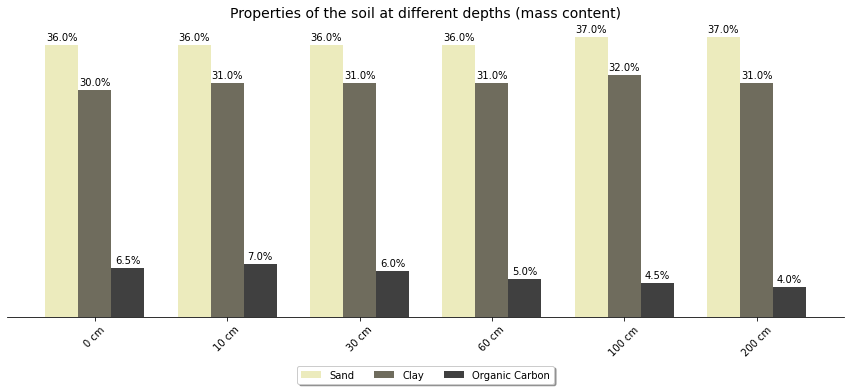

In [9]:
#plot the profile of the soil regarding sand and clay and organic carbon content at the location of interest
# Clay and organic content profiles.
profile_clay = local_profile(clay, poi, scale)
profile_orgc = local_profile(orgc, poi, scale)

# Data visualization in the form of a bar plot.
fig, ax = plt.subplots(figsize=(15, 6))
ax.axes.get_yaxis().set_visible(False)

# Definition of label locations.
x = np.arange(len(olm_bands))

# Definition of the bar width.
width = 0.25

# Bar plot representing the sand content profile.
rect1 = ax.bar(
    x - width,
    [round(100 * profile_sand[b], 2) for b in olm_bands],
    width,
    label="Sand",
    color="#ecebbd",
)

# Bar plot representing the clay content profile.
rect2 = ax.bar(
    x,
    [round(100 * profile_clay[b], 2) for b in olm_bands],
    width,
    label="Clay",
    color="#6f6c5d",
)

# Bar plot representing the organic carbon content profile.
rect3 = ax.bar(
    x + width,
    [round(100 * profile_orgc[b], 2) for b in olm_bands],
    width,
    label="Organic Carbon",
    color="black",
    alpha=0.75,
)

# Definition of a function to attach a label to each bar.
def autolabel_soil_prop(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(
            "{}".format(height) + "%",
            xy=(rect.get_x() + rect.get_width() / 2, height),
            xytext=(0, 3),  # 3 points vertical offset.
            textcoords="offset points",
            ha="center",
            va="bottom",
            fontsize=10,
        )


# Application of the function to each barplot.
autolabel_soil_prop(rect1)
autolabel_soil_prop(rect2)
autolabel_soil_prop(rect3)

# Title of the plot.
ax.set_title("Properties of the soil at different depths (mass content)", fontsize=14)

# Properties of x/y labels and ticks.
ax.set_xticks(x)
x_labels = [str(d) + " cm" for d in olm_depths]
ax.set_xticklabels(x_labels, rotation=45, fontsize=10)

ax.spines["left"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

# Shrink current axis's height by 10% on the bottom.
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])

# Add a legend below current axis.
ax.legend(
    loc="upper center", bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=3
)

plt.show()

In [10]:
#Expression to calculate hydraulic properties

# Conversion of organic carbon content into organic matter content.
orgm = orgc.multiply(1.724)

# Organic matter content profile.
profile_orgm = local_profile(orgm, poi, scale)
print("Organic Matter content profile at the location of interest:\n", profile_orgm)

Organic Matter content profile at the location of interest:
 {'b0': 0.112, 'b10': 0.121, 'b100': 0.078, 'b200': 0.069, 'b30': 0.103, 'b60': 0.086}


In [11]:
# Initialization of two constant images for wilting point and field capacity.
wilting_point = ee.Image(0)
field_capacity = ee.Image(0)

# Calculation for each standard depth using a loop.
for key in olm_bands:
    # Getting sand, clay and organic matter at the appropriate depth.
    si = sand.select(key)
    ci = clay.select(key)
    oi = orgm.select(key)

    # Calculation of the wilting point.
    # The theta_1500t parameter is needed for the given depth.
    theta_1500ti = (
        ee.Image(0)
        .expression(
            "-0.024 * S + 0.487 * C + 0.006 * OM + 0.005 * (S * OM)\
        - 0.013 * (C * OM) + 0.068 * (S * C) + 0.031",
            {
                "S": si,
                "C": ci,
                "OM": oi,
            },
        )
        .rename("T1500ti")
    )

    # Final expression for the wilting point.
    wpi = theta_1500ti.expression(
        "T1500ti + ( 0.14 * T1500ti - 0.002)", {"T1500ti": theta_1500ti}
    ).rename("wpi")

    # Add as a new band of the global wilting point ee.Image.
    # Do not forget to cast the type with float().
    wilting_point = wilting_point.addBands(wpi.rename(key).float())

    # Same process for the calculation of the field capacity.
    # The parameter theta_33t is needed for the given depth.
    theta_33ti = (
        ee.Image(0)
        .expression(
            "-0.251 * S + 0.195 * C + 0.011 * OM +\
        0.006 * (S * OM) - 0.027 * (C * OM)+\
        0.452 * (S * C) + 0.299",
            {
                "S": si,
                "C": ci,
                "OM": oi,
            },
        )
        .rename("T33ti")
    )

    # Final expression for the field capacity of the soil.
    fci = theta_33ti.expression(
        "T33ti + (1.283 * T33ti * T33ti - 0.374 * T33ti - 0.015)",
        {"T33ti": theta_33ti.select("T33ti")},
    )

    # Add a new band of the global field capacity ee.Image.
    field_capacity = field_capacity.addBands(fci.rename(key).float())

In [12]:
#see the result around our location of interest
profile_wp = local_profile(wilting_point, poi, scale)
profile_fc = local_profile(field_capacity, poi, scale)

print("Wilting point profile:\n", profile_wp)
print("Field capacity profile:\n", profile_fc)

Wilting point profile:
 {'b0': 0.199, 'b10': 0.205, 'b100': 0.21, 'b200': 0.205, 'b30': 0.205, 'b60': 0.205}
Field capacity profile:
 {'b0': 0.312, 'b10': 0.317, 'b100': 0.32, 'b200': 0.315, 'b30': 0.317, 'b60': 0.317}


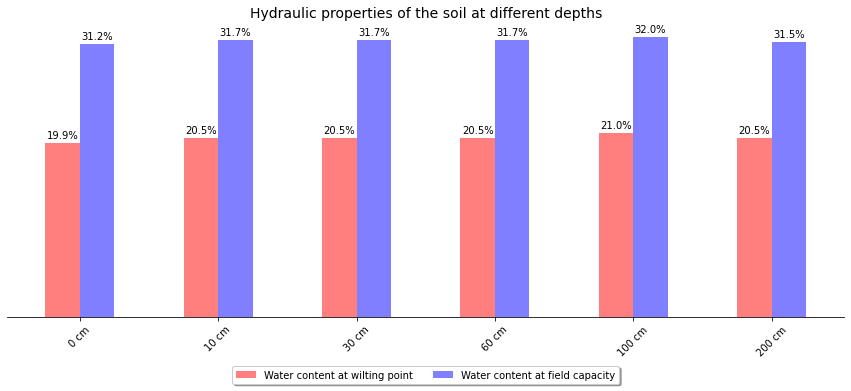

In [13]:
#display using barplots for better visualization
fig, ax = plt.subplots(figsize=(15, 6))
ax.axes.get_yaxis().set_visible(False)

# Definition of the label locations.
x = np.arange(len(olm_bands))

# Width of the bar of the barplot.
width = 0.25

# Barplot associated with the water content at the wilting point.
rect1 = ax.bar(
    x - width / 2,
    [round(profile_wp[b] * 100, 2) for b in olm_bands],
    width,
    label="Water content at wilting point",
    color="red",
    alpha=0.5,
)

# Barplot associated with the water content at the field capacity.
rect2 = ax.bar(
    x + width / 2,
    [round(profile_fc[b] * 100, 2) for b in olm_bands],
    width,
    label="Water content at field capacity",
    color="blue",
    alpha=0.5,
)

# Add Labels on top of bars.
autolabel_soil_prop(rect1)
autolabel_soil_prop(rect2)

# Title of the plot.
ax.set_title("Hydraulic properties of the soil at different depths", fontsize=14)

# Properties of x/y labels and ticks.
ax.set_xticks(x)
x_labels = [str(d) + " cm" for d in olm_depths]
ax.set_xticklabels(x_labels, rotation=45, fontsize=10)

ax.spines["left"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

# Shrink current axis's height by 10% on the bottom.
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])

# Put a legend below current axis.
ax.legend(
    loc="upper center", bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=2
)

plt.show()

In [14]:
#Getting meteorological datasets

#Datasets exploration

# Import precipitation.
pr = (
    ee.ImageCollection("UCSB-CHG/CHIRPS/DAILY")
    .select("precipitation")
    .filterDate(i_date, f_date)
)

# Import potential evaporation PET and its quality indicator ET_QC.
pet = (
    ee.ImageCollection("MODIS/006/MOD16A2")
    .select(["PET", "ET_QC"])
    .filterDate(i_date, f_date)
)

In [15]:
# Evaluate local precipitation conditions.
local_pr = pr.getRegion(poi, scale).getInfo()
pprint.pprint(local_pr[:5])

[['id', 'longitude', 'latitude', 'time', 'precipitation'],
 ['20150101', 29.559064423952858, -1.441796031011832, 1420070400000, 0],
 ['20150102', 29.559064423952858, -1.441796031011832, 1420156800000, 0],
 ['20150103', 29.559064423952858, -1.441796031011832, 1420243200000, 0],
 ['20150104', 29.559064423952858, -1.441796031011832, 1420329600000, 0]]


In [16]:
#procedure to get meteorological data around a given location in form of a pandas.DataFrame
def ee_array_to_df(arr, list_of_bands):
    """Transforms client-side ee.Image.getRegion array to pandas.DataFrame."""
    df = pd.DataFrame(arr)

    # Rearrange the header.
    headers = df.iloc[0]
    df = pd.DataFrame(df.values[1:], columns=headers)

    # Convert the data to numeric values.
    for band in list_of_bands:
        df[band] = pd.to_numeric(df[band], errors="coerce")

    # Convert the time field into a datetime.
    df["datetime"] = pd.to_datetime(df["time"], unit="ms")

    # Keep the columns of interest.
    df = df[["time", "datetime", *list_of_bands]]

    # The datetime column is defined as index.
    df = df.set_index("datetime")

    return df

In [17]:
#apply the function and see the head of the resulting pandas.DataFrame
pr_df = ee_array_to_df(local_pr, ["precipitation"])
pr_df.head(10)

,time,precipitation
datetime,,
2015-01-01,1420070400000,0.0
2015-01-02,1420156800000,0.0
2015-01-03,1420243200000,0.0
2015-01-04,1420329600000,0.0
2015-01-05,1420416000000,0.0
2015-01-06,1420502400000,0.0
2015-01-07,1420588800000,0.0
2015-01-08,1420675200000,0.0
2015-01-09,1420761600000,0.0


In [18]:
#do the same for potential evaporation
# Evaluate local potential evapotranspiration.
local_pet = pet.getRegion(poi, scale).getInfo()

# Transform the result into a pandas dataframe.
pet_df = ee_array_to_df(local_pet, ["PET", "ET_QC"])
pet_df.head(5)

,time,PET,ET_QC
datetime,,,
2015-01-01,1420070400000,359.0,0
2015-01-09,1420761600000,435.0,0
2015-01-17,1421452800000,415.0,0
2015-01-25,1422144000000,548.0,0
2015-02-02,1422835200000,422.0,0


In [19]:
#Resampling the time resolution of an ee.ImageCollection
def sum_resampler(coll, freq, unit, scale_factor, band_name):
    """
    This function aims to resample the time scale of an ee.ImageCollection.
    The function returns an ee.ImageCollection with the averaged sum of the
    band on the selected frequency.

    coll: (ee.ImageCollection) only one band can be handled
    freq: (int) corresponds to the resampling frequence
    unit: (str) corresponds to the resampling time unit.
                must be 'day', 'month' or 'year'
    scale_factor (float): scaling factor used to get our value in the good unit
    band_name (str) name of the output band
    """

    # Define initial and final dates of the collection.
    firstdate = ee.Date(
        coll.sort("system:time_start", True).first().get("system:time_start")
    )

    lastdate = ee.Date(
        coll.sort("system:time_start", False).first().get("system:time_start")
    )

    # Calculate the time difference between both dates.
    # https://developers.google.com/earth-engine/apidocs/ee-date-difference
    diff_dates = lastdate.difference(firstdate, unit)

    # Define a new time index (for output).
    new_index = ee.List.sequence(0, ee.Number(diff_dates), freq)

    # Define the function that will be applied to our new time index.
    def apply_resampling(date_index):
        # Define the starting date to take into account.
        startdate = firstdate.advance(ee.Number(date_index), unit)

        # Define the ending date to take into account according
        # to the desired frequency.
        enddate = firstdate.advance(ee.Number(date_index).add(freq), unit)

        # Calculate the number of days between starting and ending days.
        diff_days = enddate.difference(startdate, "day")

        # Calculate the composite image.
        image = (
            coll.filterDate(startdate, enddate)
            .mean()
            .multiply(diff_days)
            .multiply(scale_factor)
            .rename(band_name)
        )

        # Return the final image with the appropriate time index.
        return image.set("system:time_start", startdate.millis())

    # Map the function to the new time index.
    res = new_index.map(apply_resampling)

    # Transform the result into an ee.ImageCollection.
    res = ee.ImageCollection(res)

    return res

In [20]:
# Apply the resampling function to the precipitation dataset.
pr_m = sum_resampler(pr, 1, "month", 1, "pr")

# Evaluate the result at the location of interest.
pprint.pprint(pr_m.getRegion(poi, scale).getInfo()[:5])

[['id', 'longitude', 'latitude', 'time', 'pr'],
 ['0',
  29.559064423952858,
  -1.441796031011832,
  1420070400000,
  49.593496680259705],
 ['1',
  29.559064423952858,
  -1.441796031011832,
  1422748800000,
  128.25636672973633],
 ['2',
  29.559064423952858,
  -1.441796031011832,
  1425168000000,
  218.4937605857849],
 ['3',
  29.559064423952858,
  -1.441796031011832,
  1427846400000,
  204.35531616210938]]


In [21]:
# Apply the resampling function to the PET dataset.
pet_m = sum_resampler(pet.select("PET"), 1, "month", 0.0125, "pet")

# Evaluate the result at the location of interest.
pprint.pprint(pet_m.getRegion(poi, scale).getInfo()[:5])

[['id', 'longitude', 'latitude', 'time', 'pet'],
 ['0',
  29.559064423952858,
  -1.441796031011832,
  1420070400000,
  170.20937500000002],
 ['1',
  29.559064423952858,
  -1.441796031011832,
  1422748800000,
  113.22500000000001],
 ['2',
  29.559064423952858,
  -1.441796031011832,
  1425168000000,
  189.29375000000002],
 ['3', 29.559064423952858, -1.441796031011832, 1427846400000, 78.9375]]


In [22]:
# Combine precipitation and evapotranspiration.
meteo = pr_m.combine(pet_m)

# Import meteorological data as an array at the location of interest.
meteo_arr = meteo.getRegion(poi, scale).getInfo()

# Print the result.
pprint.pprint(meteo_arr[:5])

[['id', 'longitude', 'latitude', 'time', 'pr', 'pet'],
 ['0',
  29.559064423952858,
  -1.441796031011832,
  1420070400000,
  49.593496680259705,
  170.20937500000002],
 ['1',
  29.559064423952858,
  -1.441796031011832,
  1422748800000,
  128.25636672973633,
  113.22500000000001],
 ['10',
  29.559064423952858,
  -1.441796031011832,
  1446336000000,
  223.4414005279541,
  87.125],
 ['11',
  29.559064423952858,
  -1.441796031011832,
  1448928000000,
  155.3278636932373,
  126.45416666666665]]


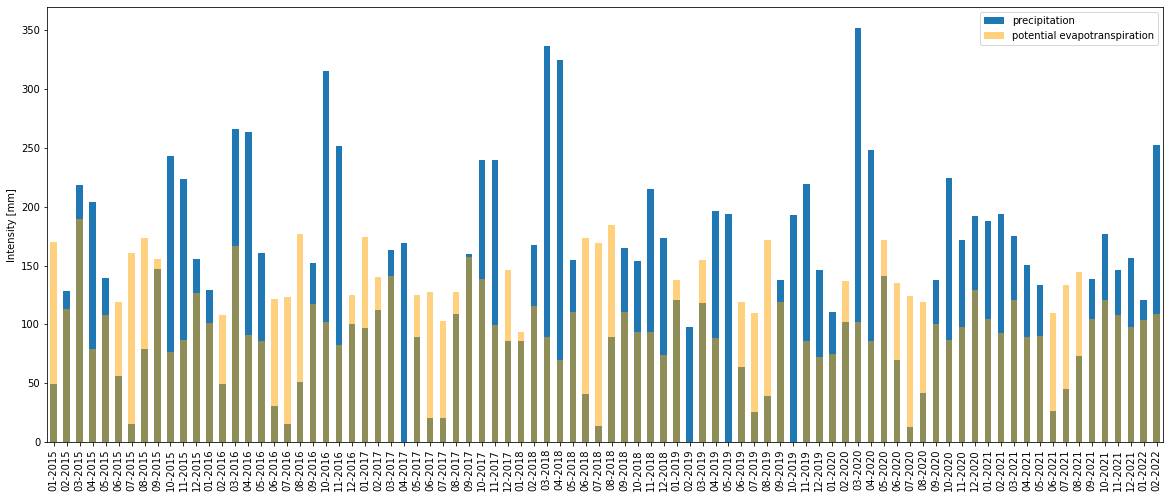

In [23]:
#evaluate the result on our location of interest

# Transform the array into a pandas dataframe and sort the index.
meteo_df = ee_array_to_df(meteo_arr, ["pr", "pet"]).sort_index()

# Data visualization
fig, ax = plt.subplots(figsize=(20, 8))

# Barplot associated with precipitations.
meteo_df["pr"].plot(kind="bar", ax=ax, label="precipitation")

# Barplot associated with potential evapotranspiration.
meteo_df["pet"].plot(
    kind="bar", ax=ax, label="potential evapotranspiration", color="orange", alpha=0.5
)

# Add a legend.
ax.legend()

# Add some x/y-labels properties.
ax.set_ylabel("Intensity [mm]")
ax.set_xlabel(None)

# Define the date format and shape of x-labels.
x_labels = meteo_df.index.strftime("%m-%Y")
ax.set_xticklabels(x_labels, rotation=90, fontsize=10)

plt.show()

In [24]:
#Implementation of the TM procedure
zr = ee.Image(0.5)
p = ee.Image(0.5)

In [25]:
#also consider an averaged value between reference depths of the water content at wilting point and field capacity
def olm_prop_mean(olm_image, band_output_name):
    """
    This function calculates an averaged value of
    soil properties between reference depths.
    """
    mean_image = olm_image.expression(
        "(b0 + b10 + b30 + b60 + b100 + b200) / 6",
        {
            "b0": olm_image.select("b0"),
            "b10": olm_image.select("b10"),
            "b30": olm_image.select("b30"),
            "b60": olm_image.select("b60"),
            "b100": olm_image.select("b100"),
            "b200": olm_image.select("b200"),
        },
    ).rename(band_output_name)

    return mean_image


# Apply the function to field capacity and wilting point.
fcm = olm_prop_mean(field_capacity, "fc_mean")
wpm = olm_prop_mean(wilting_point, "wp_mean")

# Calculate the theoretical available water.
taw = (
    (fcm.select("fc_mean").subtract(wpm.select("wp_mean"))).multiply(1000).multiply(zr)
)

# Calculate the stored water at the field capacity.
stfc = taw.multiply(p)

In [26]:
# Define the initial time (time0) according to the start of the collection.
time0 = meteo.first().get("system:time_start")

In [27]:
# Initialize all bands describing the hydric state of the soil.
# Do not forget to cast the type of the data with a .float().
# Initial recharge.
initial_rech = ee.Image(0).set("system:time_start", time0).select([0], ["rech"]).float()

# Initialization of APWL.
initial_apwl = ee.Image(0).set("system:time_start", time0).select([0], ["apwl"]).float()

# Initialization of ST.
initial_st = stfc.set("system:time_start", time0).select([0], ["st"]).float()

# Initialization of precipitation.
initial_pr = ee.Image(0).set("system:time_start", time0).select([0], ["pr"]).float()

# Initialization of potential evapotranspiration.
initial_pet = ee.Image(0).set("system:time_start", time0).select([0], ["pet"]).float()

In [28]:
#combine all these bands into one ee.Image adding new bands to the first using the ee.Image.addBands method

initial_image = initial_rech.addBands(
    ee.Image([initial_apwl, initial_st, initial_pr, initial_pet])
)
image_list = ee.List([initial_image])

In [29]:
#Recharge calculation

def recharge_calculator(image, image_list):
    """
    Contains operations made at each iteration.
    """
    # Determine the date of the current ee.Image of the collection.
    localdate = image.date().millis()

    # Import previous image stored in the list.
    prev_im = ee.Image(ee.List(image_list).get(-1))

    # Import previous APWL and ST.
    prev_apwl = prev_im.select("apwl")
    prev_st = prev_im.select("st")

    # Import current precipitation and evapotranspiration.
    pr_im = image.select("pr")
    pet_im = image.select("pet")

    # Initialize the new bands associated with recharge, apwl and st.
    # DO NOT FORGET TO CAST THE TYPE WITH .float().
    new_rech = (
        ee.Image(0)
        .set("system:time_start", localdate)
        .select([0], ["rech"])
        .float()
    )

    new_apwl = (
        ee.Image(0)
        .set("system:time_start", localdate)
        .select([0], ["apwl"])
        .float()
    )

    new_st = (
        prev_st.set("system:time_start", localdate).select([0], ["st"]).float()
    )

    # Calculate bands depending on the situation using binary layers with
    # logical operations.

    # CASE 1.
    # Define zone1: the area where PET > P.
    zone1 = pet_im.gt(pr_im)

    # Calculation of APWL in zone 1.
    zone1_apwl = prev_apwl.add(pet_im.subtract(pr_im)).rename("apwl")
    # Implementation of zone 1 values for APWL.
    new_apwl = new_apwl.where(zone1, zone1_apwl)

    # Calculate ST in zone 1.
    zone1_st = prev_st.multiply(
        ee.Image.exp(zone1_apwl.divide(stfc).multiply(-1))
    ).rename("st")
    # Implement ST in zone 1.
    new_st = new_st.where(zone1, zone1_st)

    # CASE 2.
    # Define zone2: the area where PET <= P.
    zone2 = pet_im.lte(pr_im)

    # Calculate ST in zone 2.
    zone2_st = prev_st.add(pr_im).subtract(pet_im).rename("st")
    # Implement ST in zone 2.
    new_st = new_st.where(zone2, zone2_st)

    # CASE 2.1.
    # Define zone21: the area where PET <= P and ST >= STfc.
    zone21 = zone2.And(zone2_st.gte(stfc))

    # Calculate recharge in zone 21.
    zone21_re = zone2_st.subtract(stfc).rename("rech")
    # Implement recharge in zone 21.
    new_rech = new_rech.where(zone21, zone21_re)
    # Implement ST in zone 21.
    new_st = new_st.where(zone21, stfc)

    # CASE 2.2.
    # Define zone 22: the area where PET <= P and ST < STfc.
    zone22 = zone2.And(zone2_st.lt(stfc))

    # Calculate APWL in zone 22.
    zone22_apwl = (
        stfc.multiply(-1).multiply(ee.Image.log(zone2_st.divide(stfc))).rename("apwl")
    )
    # Implement APWL in zone 22.
    new_apwl = new_apwl.where(zone22, zone22_apwl)

    # Create a mask around area where recharge can effectively be calculated.
    # Where we have have PET, P, FCm, WPm (except urban areas, etc.).
    mask = pet_im.gte(0).And(pr_im.gte(0)).And(fcm.gte(0)).And(wpm.gte(0))

    # Apply the mask.
    new_rech = new_rech.updateMask(mask)

    # Add all Bands to our ee.Image.
    new_image = new_rech.addBands(ee.Image([new_apwl, new_st, pr_im, pet_im]))

    # Add the new ee.Image to the ee.List.
    return ee.List(image_list).add(new_image)

In [30]:
# Iterate the user-supplied function to the meteo collection.
rech_list = meteo.iterate(recharge_calculator, image_list)

# Remove the initial image from our list.
rech_list = ee.List(rech_list).remove(initial_image)

# Transform the list into an ee.ImageCollection.
rech_coll = ee.ImageCollection(rech_list)

In [31]:
# look at the result around the location of interest
arr = rech_coll.getRegion(poi, scale).getInfo()
rdf = ee_array_to_df(arr, ["pr", "pet", "apwl", "st", "rech"]).sort_index()
rdf.head(12)

,time,pr,pet,apwl,st,rech
datetime,,,,,,
2015-01-01,1420070400000,49.593497,170.209375,120.615878,3.684569e-01,0.000000
2015-02-01,1422748800000,128.256367,113.225000,16.547521,1.539982e+01,0.000000
2015-03-01,1425168000000,218.493761,189.293750,0.000000,2.787953e+01,1.320482
2015-04-01,1427846400000,204.355316,78.937500,0.000000,2.787953e+01,97.576864
2015-05-01,1430438400000,139.616526,107.918750,0.000000,2.787953e+01,31.697776
2015-06-01,1433116800000,56.159334,119.062500,62.903166,1.615437e+00,0.000000
2015-07-01,1435708800000,15.272697,160.715625,145.442928,1.512315e-01,0.000000
2015-08-01,1438387200000,79.394130,173.212500,93.818370,9.634429e-01,0.000000
2015-09-01,1441065600000,146.890283,155.625000,252.171014,5.733491e-11,0.000000


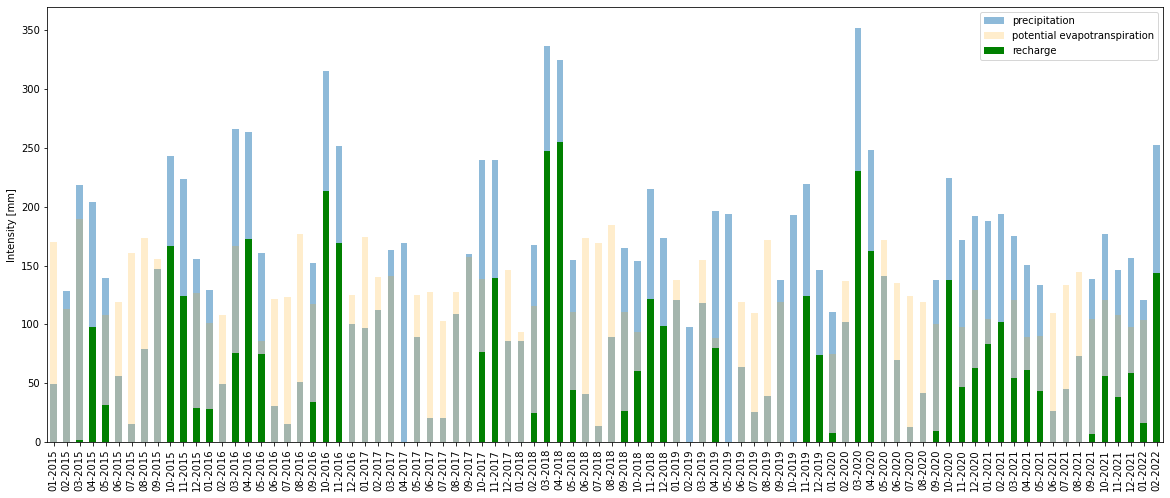

In [32]:
#display in the form of a barplot for better visualization

# Data visualization in the form of barplots.
fig, ax = plt.subplots(figsize=(20, 8))

# Barplot associated with precipitation.
rdf["pr"].plot(kind="bar", ax=ax, label="precipitation", alpha=0.5)

# Barplot associated with potential evapotranspiration.
rdf["pet"].plot(
    kind="bar", ax=ax, label="potential evapotranspiration", color="orange", alpha=0.2
)

# Barplot associated with groundwater recharge
rdf["rech"].plot(kind="bar", ax=ax, label="recharge", color="green", alpha=1)

# Add a legend.
ax.legend()

# Define x/y-labels properties.
ax.set_ylabel("Intensity [mm]")
ax.set_xlabel(None)

# Define the date format and shape of x-labels.
x_labels = rdf.index.strftime("%m-%Y")
ax.set_xticklabels(x_labels, rotation=90, fontsize=10)

plt.show()

In [33]:
# Resample the pandas dataframe on a yearly basis making the sum by year.
rdfy = rdf.resample("Y").sum()

# Calculate the mean value.
mean_recharge = rdfy["rech"].mean()

# Print the result.
print(
    "The mean annual recharge at our point of interest is", int(mean_recharge), "mm/an"
)

The mean annual recharge at our point of interest is 488 mm/an


In [34]:
#Groundwater recharge comparison between multiple places

def get_local_recharge(i_date, f_date, lon, lat, scale):
    """
    Returns a pandas df describing the cumulative groundwater
    recharge by month
    """
    # Define the location of interest with a point.
    poi = ee.Geometry.Point(lon, lat)

    # Evaluate the recharge around the location of interest.
    rarr = rech_coll.filterDate(i_date, f_date).getRegion(poi, scale).getInfo()

    # Transform the result into a pandas dataframe.
    rdf = ee_array_to_df(rarr, ["pr", "pet", "apwl", "st", "rech"]).sort_index()
    return rdf

In [35]:
# Define the second location of interest by longitude/latitude.
lon2 = 30.047686
lat2 = -2.335682

# Calculate the local recharge condition at this location.
rdf2 = get_local_recharge(i_date, f_date, lon2, lat2, scale)

# Resample the resulting pandas dataframe on a yearly basis (sum by year).
rdf2y = rdf2.resample("Y").sum()
rdf2y.head()

,pr,pet,apwl,st,rech
datetime,,,,,
2015-12-31,933.444122,2084.672917,4293.189700,25.976931,0.000000
2016-12-31,937.403771,2123.372917,5217.915248,22.175900,0.000000
2017-12-31,1009.853721,2103.891667,4209.703916,25.133948,0.000000
2018-12-31,1271.268714,1974.744792,5691.689553,77.464546,246.070116
2019-12-31,1073.870793,1948.048958,3049.365764,69.660663,45.209572


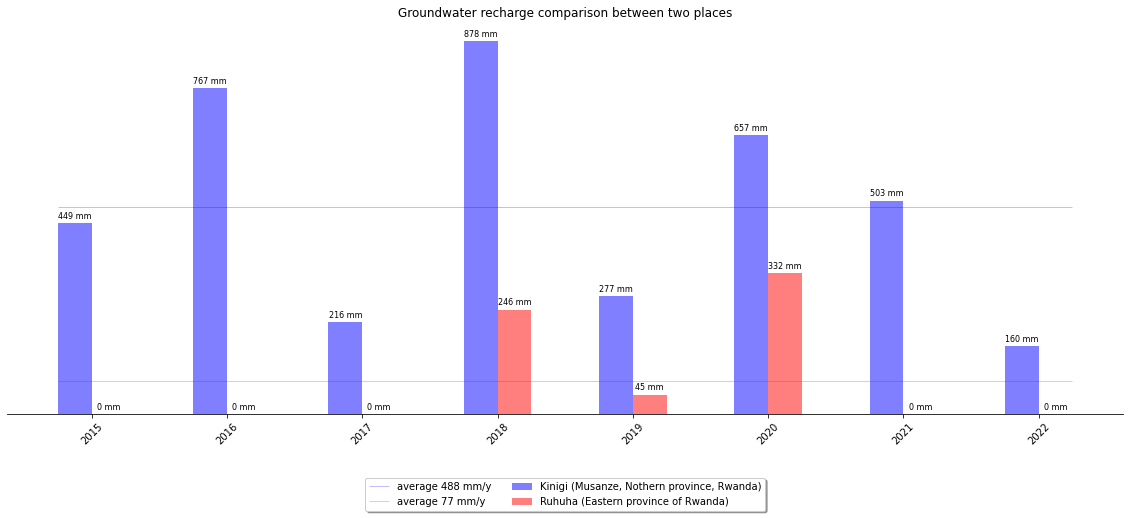

In [36]:
# Data Visualization
fig, ax = plt.subplots(figsize=(20, 8))
ax.axes.get_yaxis().set_visible(False)

# Define the x-label locations.
x = np.arange(len(rdfy))

# Define the bar width.
width = 0.25

# Bar plot associated to groundwater recharge at the 1st location of interest.
rect1 = ax.bar(
    x - width / 2, rdfy.rech, width, label="Kinigi (Musanze, Nothern province, Rwanda)", color="blue", alpha=0.5
)

# Bar plot associated to groundwater recharge at the 2nd location of interest.
rect2 = ax.bar(
    x + width / 2,
    rdf2y.rech,
    width,
    label="Ruhuha (Eastern province of Rwanda)",
    color="red",
    alpha=0.5,
)

# Define a function to attach a label to each bar.
def autolabel_recharge(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(
            "{}".format(int(height)) + " mm",
            xy=(rect.get_x() + rect.get_width() / 2, height),
            xytext=(0, 3),  # 3 points vertical offset
            textcoords="offset points",
            ha="center",
            va="bottom",
            fontsize=8,
        )


autolabel_recharge(rect1)
autolabel_recharge(rect2)

# Calculate the averaged annual recharge at both locations of interest.
place1mean = int(rdfy["rech"].mean())
place2mean = int(rdf2y["rech"].mean())

# Add an horizontal line associated with averaged annual values (location 1).
ax.hlines(
    place1mean,
    xmin=min(x) - width,
    xmax=max(x) + width,
    color="blue",
    lw=0.5,
    label="average " + str(place1mean) + " mm/y",
    alpha=0.5,
)

# Add an horizontal line associated with averaged annual values (location 2).
ax.hlines(
    place2mean,
    xmin=min(x) - width,
    xmax=max(x) + width,
    color="red",
    lw=0.5,
    label="average " + str(place2mean) + " mm/y",
    alpha=0.5,
)

# Add a title.
ax.set_title("Groundwater recharge comparison between two places", fontsize=12)

# Define some x/y-axis properties.
ax.set_xticks(x)
x_labels = rdfy.index.year.tolist()
ax.set_xticklabels(x_labels, rotation=45, fontsize=10)

ax.spines["left"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

# Shrink current axis's height by 10% on the bottom.
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9])

# Add a legend below current axis.
ax.legend(
    loc="upper center", bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=2
)

plt.show()

In [37]:
#Groundwater recharge map of Netherlands

# Calculate the averaged annual recharge.
annual_rech = rech_coll.select("rech").mean().multiply(12)

# Calculate the average annual precipitation.
annual_pr = rech_coll.select("pr").mean().multiply(12)

# Get a feature collection of administrative boundaries.
countries = ee.FeatureCollection("FAO/GAUL/2015/level0").select("ADM0_NAME")

# Filter the feature collection to subset France.
country = countries.filter(ee.Filter.eq("ADM0_NAME", "Rwanda"))

# Clip the composite ee.Images around the region of interest.
rech_country = annual_rech.clip(country)
pr_country = annual_pr.clip(country)

In [38]:
#Create an interactive map for better visualization
# Create a folium map
my_map = folium.Map(location=[-1.958251, 30.027960], zoom_start=9, zoom_control=False)

# Set visualization parameters for recharge.
rech_vis_params = {
    "bands": "rech",
    "min": 0,
    "max": 500,
    "opacity": 1,
    "palette": ["red", "orange", "yellow", "green", "blue", "purple"],
}

# Set visualization parameters for precipitation.
pr_vis_params = {
    "bands": "pr",
    "min": 500,
    "max": 1500,
    "opacity": 1,
    "palette": ["white", "blue"],
}

# Define a recharge colormap.
rech_colormap = cm.LinearColormap(
    colors=rech_vis_params["palette"],
    vmin=rech_vis_params["min"],
    vmax=rech_vis_params["max"],
)

# Define a precipitation colormap.
pr_colormap = cm.LinearColormap(
    colors=pr_vis_params["palette"],
    vmin=pr_vis_params["min"],
    vmax=pr_vis_params["max"],
)

# Caption of the recharge colormap.
rech_colormap.caption = "Average annual recharge rate (mm/year)"

# Caption of the precipitation colormap.
pr_colormap.caption = "Average annual precipitation rate (mm/year)"

# Add the precipitation composite to the map object.
my_map.add_ee_layer(pr_country, pr_vis_params, "Precipitation")

# Add the recharge composite to the map object.
my_map.add_ee_layer(rech_country, rech_vis_params, "Recharge")

# Add a marker at both locations of interest.
folium.Marker([lat, lon], popup="Area of Kinigi").add_to(my_map)
folium.Marker([lat2, lon2], popup="Area of Ruhuha").add_to(my_map)

# Add the colormaps to the map.
my_map.add_child(rech_colormap)
my_map.add_child(pr_colormap)

# Add a layer control panel to the map.
my_map.add_child(folium.LayerControl())

# Display the map.
display(my_map)